In [59]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import scikit_posthocs as sp
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict
from os import listdir

In [60]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

### Import list of all experiments

In [61]:
path='../../NGS/20230420_TnpB_CasMini_CjPAM_Libraries/CasMini/Output/Analysis/'
def list_files1(directory):
    return [f for f in listdir(directory) if 'LS' in f]

sampledf = pd.DataFrame(columns=['filename','Cell_line','Editor','Replicate'])
filelist = list_files1(path)
sampledf['filename'] = filelist
sampledf['Library'] = 'CasMini-Lib'
sampledf['Editor'] = sampledf['filename'].apply(lambda x: x.split('-')[1])
sampledf['Day'] = sampledf['filename'].apply(lambda x: x.split('_')[1].split('-')[-2][1:])
sampledf['Editor_Day'] = sampledf.apply(lambda x: x.Editor+'_'+x.Day ,axis=1)
sampledf['Replicate'] = sampledf['filename'].apply(lambda x: x.split('_')[1][-1:])
sampledf['Control'] = sampledf['filename'].apply(lambda x: True if 'ctrl' in x else False)
# set values in column 'Editor' to "ctrl" if 'Control' is True
sampledf.loc[sampledf['Control'] == True, 'Editor'] = 'ctrl'

sampledf['repname'] = sampledf.apply(lambda x: x.Editor+"_"+x.Day+"_"+x.Replicate,axis=1)
#sampledf['Cell_line_Editor'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor,axis=1)
#sampledf['repname'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor+"_"+x.Replicate,axis=1)

In [62]:
sampledf

,filename,Cell_line,Editor,Replicate,Library,Day,Editor_Day,Control,repname
0,20230420_LS-p633-ctrl-D5-R3_analysisdf_focused...,NaN,ctrl,3,CasMini-Lib,5,p633_5,True,ctrl_5_3
1,20230420_LS-p633-ctrl-D10-R1_analysisdf_focuse...,NaN,ctrl,1,CasMini-Lib,10,p633_10,True,ctrl_10_1
2,20230420_LS-p633-ctrl-D10-R2_analysisdf_focuse...,NaN,ctrl,2,CasMini-Lib,10,p633_10,True,ctrl_10_2
3,20230420_LS-p633-ctrl-D10-R3_analysisdf_focuse...,NaN,ctrl,3,CasMini-Lib,10,p633_10,True,ctrl_10_3
4,20230420_LS-p633-ctrl-D3-R1_analysisdf_focused...,NaN,ctrl,1,CasMini-Lib,3,p633_3,True,ctrl_3_1
5,20230420_LS-p633-ctrl-D3-R2_analysisdf_focused...,NaN,ctrl,2,CasMini-Lib,3,p633_3,True,ctrl_3_2
6,20230420_LS-p633-ctrl-D3-R3_analysisdf_focused...,NaN,ctrl,3,CasMini-Lib,3,p633_3,True,ctrl_3_3
7,20230420_LS-p633-ctrl-D5-R1_analysisdf_focused...,NaN,ctrl,1,CasMini-Lib,5,p633_5,True,ctrl_5_1
8,20230420_LS-p633-ctrl-D7-R1_analysisdf_focused...,NaN,ctrl,1,CasMini-Lib,7,p633_7,True,ctrl_7_1
9,20230420_LS-p633-ctrl-D7-R2_analysisdf_focused...,NaN,ctrl,2,CasMini-Lib,7,p633_7,True,ctrl_7_2


In [63]:
templatedf = pd.read_csv('CasMINI_Lib.csv')

### Calculate control characteristics for each experimental setup

In [64]:
ctrllist = sampledf[sampledf['Editor'] == 'ctrl']
ctrldf = templatedf.copy()
for index, row in ctrllist.iterrows():
    controlrepdf = pd.read_csv(path+row.filename)
    ctrldf[row.repname+'_totalreads'] = controlrepdf['totalreads']
    controlrepdf['percentageindel'] = controlrepdf.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
    controlrepdf['percentageunedited'] = controlrepdf.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
    ctrldf[row.repname+'_percentageunedited'] = controlrepdf['percentageunedited']
    ctrldf[row.repname+'_percentageindel'] = controlrepdf['percentageindel']
    ctrldf[row.repname+'_uneditedcount'] = controlrepdf['uneditedcount']
    ctrldf[row.repname+'_indelcount'] = controlrepdf['indelcount']

for index, row in ctrllist.iterrows():    
    ctrldf = ctrldf[ctrldf[row.repname+'_totalreads'] > 100]
    ctrldf = ctrldf[ctrldf[row.repname+'_percentageindel'] < 30]

In [65]:
editordaylist = sampledf['Editor_Day'].unique()
editordaylist = [x for x in editordaylist if not 'ctrl' in x]
experimentdict = {}
for editor_day in editordaylist:
    experimentdf = templatedf.copy()
    for index, row in sampledf[sampledf['Editor_Day'] == editor_day].iterrows():
        dataframe = pd.read_csv(path+row.filename)
        dataframename = row.Editor+"_"+row.Day+"_"+row.Replicate
        day = row.Day
        experimentdf[dataframename+'_totalreads'] = dataframe['totalreads']
        dataframe['percentageindel'] = dataframe.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
        dataframe['percentageunedited'] = dataframe.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
        experimentdf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
        experimentdf[dataframename+'_percentageindel'] = dataframe['percentageindel']
        experimentdf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
        experimentdf[dataframename+'_indelcount'] = dataframe['indelcount']
        
    replicates = list(sampledf[sampledf['Editor_Day'] == editor_day].repname)
    controldf = sampledf[(sampledf['Editor'] == 'ctrl') & (sampledf['Day'] == day)]    
    #controlname = controldf['Cell_line_Editor'] + '_' + controldf['Replicate']
    
    ctrluneditedlist = []
    ctrlindellist = []
    lib = "Nme"
    for index, row in controldf.iterrows():
        ctrluneditedlist.append(row.repname+'_percentageunedited')
        ctrlindellist.append(row.repname+'_percentageindel')
        
    experimentdf['ctr'+'_'+day+'_percentageunedited'] = ctrldf[ctrluneditedlist].mean(axis=1)
    experimentdf['ctr'+'_'+day+'_percentageindel'] = ctrldf[ctrlindellist].mean(axis=1)

    cutoff = 100
    initialtemplen = len(experimentdf)

    for replicate in replicates:
        experimentdf = experimentdf[experimentdf[replicate+'_totalreads']>cutoff]
    print(editor_day)
    print(len(experimentdf))
    print()
    experimentdict[editor_day] = experimentdf

p633_5
61

p633_10
59

p633_3
61

p633_7
61



### Calculate editing characteristics for all experimental setups
Also clip editing levels to be between 0-100.

In [66]:
sampledf_woctr = sampledf[sampledf['Editor'] != 'ctrl']

In [67]:
editordaydf = sampledf_woctr.copy()
editordaydf = editordaydf[editordaydf['Replicate'] == "1"]
editordaydf = editordaydf.set_index('Editor_Day')

cols = ['Editor', 'Library', 'Day']
editordaydf = editordaydf[cols]
editordaydf

,Editor,Library,Day
Editor_Day,,,
p633_10,p633,CasMini-Lib,10
p633_3,p633,CasMini-Lib,3
p633_5,p633,CasMini-Lib,5
p633_7,p633,CasMini-Lib,7


In [68]:



for editor_day in experimentdict:
    print(editor_day)
    replicatelist = list(sampledf_woctr[sampledf_woctr['Editor_Day'] == editor_day]['repname'])
    day = editor_day.split('_')[1]
    ctrname = 'ctr'+'_'+day
    
    for replicate in replicatelist:
        print(replicate)
        repnr = replicate.split('_')[-1]
        experimentdict[editor_day][replicate+'_percentageindel_corrected_individual'] = experimentdict[editor_day].apply(lambda x: ((x[replicate+'_percentageindel']-x[ctrname+'_percentageindel'])/((100-x[ctrname+'_percentageindel'])/100)),axis=1)
        editordaydf.at[editor_day,repnr +'_meanindel'] = None
        editordaydf.at[editor_day,repnr +'_meanindel'] = experimentdict[editor_day][[replicate +'_percentageindel_corrected_individual']].mean()
        
    allreps = []
    for index,row in sampledf_woctr[sampledf_woctr['Editor_Day'] == editor_day].iterrows():
        rep = row.Editor_Day+'_'+row.Replicate
        allreps.append(rep)
        
    print(allreps)    
    experimentdict[editor_day][editor_day+'_averageindel'] = experimentdict[editor_day][[x +'_percentageindel_corrected_individual' for x in allreps]].mean(axis=1)
    
       
    # Clip editing rates to be between 0 and 100
    experimentdict[editor_day][editor_day+'_averageindel'] = experimentdict[editor_day][editor_day+'_averageindel'].clip(0,100)
    
    experimentdict[editor_day] = experimentdict[editor_day].dropna(subset=[editor_day+'_averageindel'])
    
    
    
    
    
    editordaydf.at[editor_day,'numberofvariants'] = len(experimentdict[editor_day])
    editordaydf.at[editor_day,'meanindel'] = experimentdict[editor_day][editor_day+'_averageindel'].mean()
    editordaydf.at[editor_day,'standarddeviation'] = experimentdict[editor_day][editor_day+'_averageindel'].std()
    # experimentdict[editor_day].to_csv('./AnalysisFiles/summary/20230319_'+editor_day+'_analysis_dataframe.csv')
    path='../../NGS/20230420_TnpB_CasMini_CjPAM_Libraries/CasMini/Output/Analysis/summary/'
    experimentdict[editor_day].to_csv(path+'20230420_'+editor_day+'_analysis_dataframe.csv')

p633_5
p633_5_1
p633_5_3
['p633_5_1', 'p633_5_3']
p633_10
p633_10_1
p633_10_2
p633_10_3
['p633_10_1', 'p633_10_2', 'p633_10_3']
p633_3
p633_3_1
p633_3_2
p633_3_3
['p633_3_1', 'p633_3_2', 'p633_3_3']
p633_7
p633_7_1
p633_7_2
p633_7_3
['p633_7_1', 'p633_7_2', 'p633_7_3']


In [69]:

# do the following for all except Editor day "p633_5" where we only have 2 replicates
editordaydf.at['p633_5','2_meanindel'] = np.nan
editordaydf.at['p633_5','2_std'] = np.nan

for index, row in editordaydf.iterrows():
    editordaydf.at[index,'replicate_meanindel'] = (row['1_meanindel'] + row['2_meanindel'] + row['3_meanindel']) / 3
    editordaydf.at[index,'replicate_std'] = np.std([row['1_meanindel'],row['2_meanindel'],row['3_meanindel']])


editordaydf.at['p633_5','replicate_meanindel'] = (editordaydf.at['p633_5','1_meanindel'] + editordaydf.at['p633_5','3_meanindel']) / 2
editordaydf.at['p633_5','replicate_std'] = np.std([editordaydf.at['p633_5','1_meanindel'],editordaydf.at['p633_5','3_meanindel']])


In [70]:
editordaydf['Day'] = editordaydf['Day'].apply(lambda x: int(x))
editordaydf = editordaydf.sort_values('Day')
editordaydf = editordaydf.sort_values('Editor')
editordaydf['filename'] = editordaydf.apply(lambda x: '20230420_'+x.Editor+'_'+str(x.Day)+'_analysis_dataframe.csv',axis=1)
path='../../NGS/20230420_TnpB_CasMini_CjPAM_Libraries/CasMini/Output/Analysis/summary/'

editordaydf.to_csv(path+'20230420_CasMini_LS_summary_mean_std.csv')
editordaydf

,Editor,Library,Day,1_meanindel,3_meanindel,numberofvariants,meanindel,standarddeviation,2_meanindel,2_std,replicate_meanindel,replicate_std,filename
Editor_Day,,,,,,,,,,,,,
p633_3,p633,CasMini-Lib,3,0.319801,0.092772,60.0,0.359933,0.577921,0.014488,NaN,0.142354,0.129480,20230420_p633_3_analysis_dataframe.csv
p633_5,p633,CasMini-Lib,5,1.411062,0.594407,60.0,1.246482,2.746169,NaN,NaN,1.002735,0.408327,20230420_p633_5_analysis_dataframe.csv
p633_7,p633,CasMini-Lib,7,3.249516,1.770379,60.0,2.299433,4.029314,1.605056,NaN,2.208317,0.739326,20230420_p633_7_analysis_dataframe.csv
p633_10,p633,CasMini-Lib,10,6.972168,5.604897,58.0,5.640696,11.174627,3.696849,NaN,5.424638,1.343205,20230420_p633_10_analysis_dataframe.csv


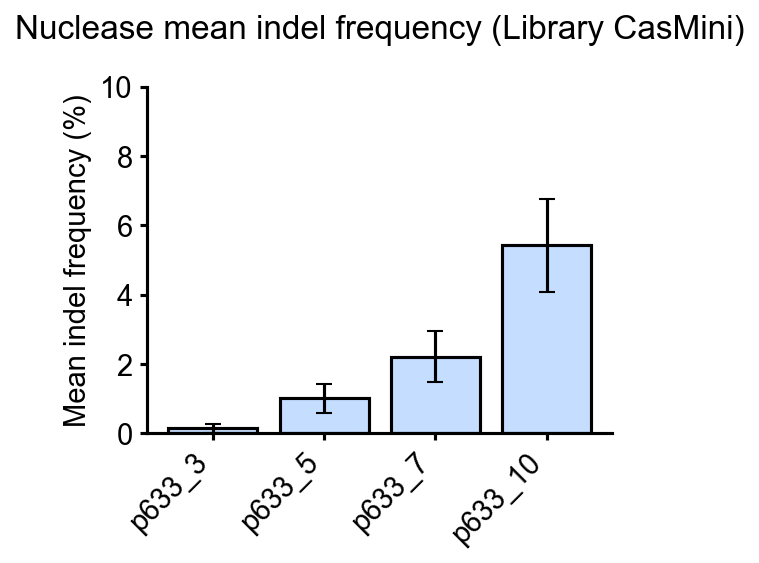

In [71]:
conditionlist = list(editordaydf.index)
meanlist = list(editordaydf.replicate_meanindel)
stdlist = list(editordaydf.replicate_std)

fig1, ax1 = plt.subplots(figsize = (4,3),dpi=150,sharex=True)
ax1.set_title('Nuclease mean indel frequency (Library CasMini)\n', fontsize=titlesize)
ax1.bar(conditionlist,meanlist,yerr=stdlist, **bar_kwargs)
ax1.set_xticks(range(len(conditionlist)))
ax1.set_xticklabels(conditionlist, ha="right")
#ax1.set_yticks(np.linspace(0,1,11))
ax1.set_ylabel('Mean indel frequency (%)', fontsize=lsize)
ax1.tick_params(axis='x', labelsize= lsize, width=1.5, rotation=45)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
ax1.set_ylim(0,10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#figurepath = 'C:\\Users\\nicol\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\'
#plt.savefig(figurepath+'Nuclease_1421_meanefficiency.pdf', format='pdf',
#        transparent=True,bbox_inches='tight')